In [26]:
#For this notebook python 3.7 is needed
#you can change the variables between comments which specify it

!pip install -r ../requirements.txt

In [27]:
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from active_semi_clustering.semi_supervised.pairwise_constraints import PCKMeans,COPKMeans, MPCKMeansMF, MPCKMeans
from active_semi_clustering.active.pairwise_constraints import ExampleOracle, ExploreConsolidate, MinMax
import active_semi_clustering.active.pairwise_constraints.random
import pickle
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
import shap
import imagehash
from PIL import Image
from operator import itemgetter

from Helper import LabelOracle,get_max_label_helper,average_hashing,color_layout_descriptor,filter_dataset,cluster_histogramm,KMajority,calculate_score_per_query, ExpertOracle

In [28]:
builder = tfds.builder('voc/2007')
builder.download_and_prepare()
datasets = builder.as_dataset()
train_data, val_data, test_data = datasets['train'], datasets['validation'], datasets['test']

_VOC_LABELS = (
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
)

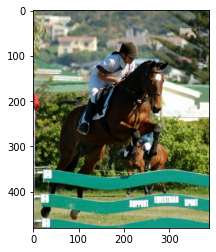

In [29]:
#TODO print some more images?
for x in train_data:
    image = x["image"]
    plt.imshow(image)
    plt.show()
    break

In [30]:

LOAD_CONSTRAINTS=False

# Here features could be disabled but then comparison in the end will not work

CLD_ENABLED = True

EFFNET_ENABLED = True

HASHING_ENABLED = True

SURF_ENABLED = True

ORB_ENABLED = True

enabled_names = []
feature_weights=[]

if CLD_ENABLED:
    enabled_names.append("cld")
    feature_weights.append(0.0065)


if EFFNET_ENABLED:
    enabled_names.append("effnet")
    feature_weights.append(2)

pooling="avg"


if HASHING_ENABLED:
    enabled_names.append("hash")
    feature_weights.append(0.45)

if SURF_ENABLED:
    enabled_names.append("surf")
    feature_weights.append(1.0)

if ORB_ENABLED:
    enabled_names.append("orb")
    feature_weights.append(1.0)

In [31]:
if EFFNET_ENABLED:
    effnet = tf.keras.applications.EfficientNetV2B1(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=None,
        pooling=pooling,
        classes=1000,
        classifier_activation="softmax",
        include_preprocessing=True,
)
#Preparing surf features
surf_clusers=1000
if SURF_ENABLED:
        surf = cv.xfeatures2d.SURF_create(hessianThreshold = 25,upright =True,extended  =True)
        def calculate_surf_image(surf,img):
            kp = surf.detect(img,None)
            kp, des = surf.compute(img, kp)
            return des

        def calculate_surf(image_list):
            des=list(map(lambda x : calculate_surf_image(surf,x),image_list))
            return np.vstack(des)

        try:
            with open("data/k_means_surf.pkl", "rb") as f:
                k_means_surf = pickle.load(f)
        except:
            image_list = list(train_data.map(lambda x: x['image']).as_numpy_iterator())
            descriptors=calculate_surf(image_list)
            print(len(descriptors))
            from sklearn.cluster import MiniBatchKMeans
            k_means_surf=MiniBatchKMeans(n_clusters=surf_clusers,reassignment_ratio=0.02,n_init=4,max_iter=200,batch_size=10000)
            print("test")
            start=time.time()

            k_means_surf.fit(descriptors)
            print(time.time()-start)
            print(metrics.calinski_harabasz_score(descriptors, k_means_surf.predict(descriptors)))

            with open("data/k_means_surf.pkl", "wb") as f:
                pickle.dump(k_means_surf, f)

        def calculate_bow(ima):
            histogram=np.zeros((surf_clusers))
            des=calculate_surf_image(surf,ima.numpy().astype(np.uint8))
            index=k_means_surf.predict(des)
            np.add.at(histogram,index,1)
            return histogram

orb_clusters=1000
if ORB_ENABLED:
    orb= cv.ORB_create()
    def calculate_orb_image(orb,image):
        kp = orb.detect(image,None)
        kp, des = orb.compute(image, kp)
        return des

    def calculate_orb(image_list):
        des=list(map(lambda x : calculate_orb_image(x),image_list))
        return np.vstack(des)

    try:
        with open("data/dumped_kmajority.pkl", "rb") as f:
                k_majority_orb = pickle.load(f)
    except Exception as e:
        print(str(e))
        print("Our K majority implemention is to slow to run here. Please use stored weights")
        ORB_ENABLED=False


    def calculate_bow_orb(ima):
        histogram=np.zeros((orb_clusters))
        des=calculate_orb_image(orb,ima.numpy().astype(np.uint8))
        des=np.unpackbits(des, axis = 1)
        index=k_majority_orb.predict(des)
        np.add.at(histogram,index,1)
        return histogram



In [32]:
from sklearn.decomposition import PCA
def get_all_features(datapoint):
    return tf.concat([datapoint[enabled_names[i]]*feature_weights[i] for i in range(len(enabled_names))],0)


class DatasetPreprocessor:
    def __init__(self):
        self.norm1=None
        self.norm2=None
        self.norm3=None
        self.norm4=None
        self.norm5=None
        self.pca1=None
        self.pca2=None
        self.pca3=None
        self.fitted=False


    def add_features_to_dataset(self,dataset,cachename,fit=False):
        if(self.fitted==False and fit==False):
            print("fit before use")
            raise Exception()
        self.fitted=True
        images = dataset.map(lambda x: x["image"])
        feature_sets = []

        # order is important here, must be same as defined in enabled_names
        if CLD_ENABLED:
            cld_features = images.map(lambda x: tf.py_function(func=color_layout_descriptor, inp=[x,8,8], Tout=np.float32),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE).cache("data/"+cachename+"_cld" if cachename!=None else '').prefetch(
                tf.data.experimental.AUTOTUNE)
            #shape=cld_features.take(1).get_single_element().shape
            #cld_features = cld_features.map(lambda t: tf.ensure_shape(t,shape)).cache("data/"+cachename+"_cld2" if cachename!=None else #'').prefetch(
            #    tf.data.experimental.AUTOTUNE)
            #if fit==True:
            #    self.norm1=tf.keras.layers.Normalization();
            #    self.norm1.adapt(cld_features)
            #cld_features=cld_features.map(lambda x:self.norm1(x))
            feature_sets.append(cld_features)


        if EFFNET_ENABLED:
            resized_images = dataset.map(lambda x: tf.image.resize(x["image"], [240, 240])).batch(1024)
            effnet_features = resized_images.map(lambda x: effnet(x)).cache().unbatch().cache("data/"+cachename+"_effnet" if cachename!=None else '').prefetch(
                tf.data.experimental.AUTOTUNE)

            if fit==True:
                self.norm2=tf.keras.layers.Normalization();
                self.norm2.adapt(effnet_features)
                self.pca = PCA(n_components=320)
                effnet_list = np.array(list(effnet_features.as_numpy_iterator()))
                self.pca.fit(effnet_list)
            effnet_features= effnet_features.map(lambda x:self.norm2(x))
            effnet_features= effnet_features.map(lambda x: tf.reshape(tf.py_function(func=self.pca.transform, inp=[tf.reshape(x,(1, -1))], Tout=np.float32),[-1]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
            feature_sets.append(effnet_features)


        if HASHING_ENABLED:
            hashing_features = images.map(lambda x: tf.py_function(func=average_hashing, inp=[x], Tout=np.float32),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
            shape=hashing_features.take(1).get_single_element().shape
            hashing_features = hashing_features.map(lambda t: tf.ensure_shape(t,shape)).cache("data/"+cachename+"_hash" if cachename!=None else '').prefetch(
                tf.data.experimental.AUTOTUNE)
            if fit==True:
                self.norm3=tf.keras.layers.Normalization();
                self.norm3.adapt(hashing_features)
            hashing_features=hashing_features.map(lambda x:self.norm3(x))
            feature_sets.append(hashing_features)



        if SURF_ENABLED:
            surf_features = images.map(lambda x: tf.py_function(func=calculate_bow, inp=[x], Tout=np.float32),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
            surf_features = surf_features.map(lambda t: tf.ensure_shape(t,(surf_clusers,))).cache("data/"+cachename+"_surf" if cachename!=None else '')
            if fit==True:
                self.norm4=tf.keras.layers.Normalization();
                self.norm4.adapt(surf_features)
                self.pca2 = PCA(n_components=250)
                surf_list = np.array(list(surf_features.as_numpy_iterator()))
                self.pca2.fit(surf_list)

            surf_features=surf_features.map(lambda x:self.norm4(x))
            surf_features=surf_features.map(lambda x: tf.reshape(tf.py_function(func=self.pca2.transform, inp=[tf.reshape(x,(1, -1))], Tout=np.float32),[-1]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
            feature_sets.append(surf_features)


        if ORB_ENABLED:
            orb_features = images.map(lambda x: tf.py_function(func=calculate_bow_orb, inp=[x], Tout=np.float32),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
            orb_features = orb_features.map(lambda t: tf.ensure_shape(t,(orb_clusters,))).cache("data/"+cachename+"_orb" if cachename!=None else '')
            if fit==True:
                self.norm5=tf.keras.layers.Normalization();
                self.norm5.adapt(orb_features)
                self.pca3 = PCA(n_components=250)
                orb_list = np.array(list(orb_features.as_numpy_iterator()))
                self.pca3.fit(orb_list)

            orb_features=orb_features.map(lambda x:self.norm5(x))
            orb_features=orb_features.map(lambda x: tf.reshape(tf.py_function(func=self.pca3.transform, inp=[tf.reshape(x,(1, -1))], Tout=np.float32),[-1]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
            feature_sets.append(orb_features)



        # We could do feature scaling here
        # this here insers the values of all featuresets into the dictionary
        complete_dataset = tf.data.Dataset.zip((dataset,) + tuple(feature_sets)).map(
            lambda x, *y: x.update({enabled_names[i]: y[i] for i in range(len(enabled_names))})\
            or x, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(lambda x:x.update({"feature":get_all_features(x)}) or x, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
        # I dediced to return dict here. They have the advantage that you can disable/add Features add will without having to condider ordering. Also we do not loose any information, which we might use later
        return complete_dataset

data_pre=DatasetPreprocessor()

# after first run this should be cached memory (needs full run)
train_complete = data_pre.add_features_to_dataset(train_data,"train",fit=True)
val_complete = data_pre.add_features_to_dataset(val_data, "val")

# forces caching
counter=0
for i in train_complete:
    counter+=1
    pass
for i in val_complete:
    pass
print(counter)

2501


In [33]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
def classifier_function_creator(clusterer,distance_measure,name_of_feature="feature"):
    cluster_algo=clusterer
    dist_func=distance_measure
    def classifier_function(image):
        image*=255.0
        ds=tf.data.Dataset.from_tensor_slices({"image":image})
        feature= data_pre.add_features_to_dataset(ds,None).map(lambda x:x[name_of_feature]).batch(image.shape[0]).get_single_element()

        dist= dist_func(feature,cluster_algo.cluster_centers_)

        dist=1/dist
        dist=np.power(dist,20)
        dist=dist/np.sum(dist,axis=1,keepdims=True)
        return dist
    return classifier_function

def classifier_function_creator2(classifier,features,labels,name_of_feature="feature"):
    clf=classifier
    clf.fit(features,labels)
    print(accuracy_score(clf.predict(features),labels))
    def classifier_function(image):
        image*=255.0
        ds=tf.data.Dataset.from_tensor_slices({"image":image})
        feature= data_pre.add_features_to_dataset(ds,None).map(lambda x:x[name_of_feature]).batch(image.shape[0]).get_single_element()
        return clf.predict_proba(feature)

    return classifier_function

In [34]:
for i in train_complete:
    print(i.keys())
    print(len(i["feature"]))
    break

dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects', 'cld', 'effnet', 'hash', 'surf', 'orb', 'feature'])
1268


In [35]:
#TODO change this to feature based selection?
# here the the number of candidate points as well as the index of the query point (0-2500) can be changed
#small number of candidate points run faster but may cause an Emptycluster Exception (the algorithm has not implemented a way to handle them)
query_point=0
number_candidate_points=500
############################


train_filtered=filter_dataset(train_complete,query_point,number_neighboors=number_candidate_points)
train_filtered_list=list(train_filtered.as_numpy_iterator())
len(train_filtered_list)

500

In [36]:
#Here the number of clusters can be changed. It has to be set beforehand because explore consolidate relies on an estimate for the number of clusters to work.
n_cluster=20
######################



# uses the label with estimated maximum size by sum of bounding box area
y = list(train_filtered.map(lambda x: (x['objects']['label'],x['objects']['bbox'],x['labels'])).map(lambda x,y,z:tf.py_function(func=get_max_label_helper, inp=[x,y,z], Tout=np.int64),num_parallel_calls=tf.data.AUTOTUNE).as_numpy_iterator())

features = np.array(list(train_filtered.map(lambda x: x['feature']).as_numpy_iterator()), dtype=np.float64)
if SURF_ENABLED:
    feature_surf = np.array(list(train_filtered.map(lambda x: x['surf']).as_numpy_iterator()), dtype=np.float64)
if EFFNET_ENABLED:
    feature_effnet = np.array(list(train_filtered.map(lambda x: x['effnet']).as_numpy_iterator()), dtype=np.float64)
if CLD_ENABLED:
    feature_cld = np.array(list(train_filtered.map(lambda x: x['cld']).as_numpy_iterator()), dtype=np.float64)
if HASHING_ENABLED:
    feature_hash = np.array(list(train_filtered.map(lambda x: x['hash']).as_numpy_iterator()), dtype=np.float64)
if ORB_ENABLED:
    feature_orb = np.array(list(train_filtered.map(lambda x: x['orb']).as_numpy_iterator()), dtype=np.float64)


In [37]:
#Here you can change the amount of queries that the algorithm can make to the oracle/expert
query_count=400
#Here you can change wether you want to give the ínput yourself or you want to rely on an oracle based on the labels.
use_expert=False

#If you choose expert oracle. Input y for must link constraint. Every other input will be cannot link.
#If you choose label oracle. You can set to use the max label which is an estimate for the biggest object based on its bounding boxes.

use_max_query=True

#Alternativly you can set this to no and pass to parameters to a heuristic function which comapres the the area of the matching and non-matching objects by bounding box
#Note that this is more of a counter example for good queries because a comparision of objects has a major problem that it generates contradicting constrains. Say we have 3 objects a small one, medium one and a big one. The small and medium, medium and big now will generate must links, while the small and big objects can generate a cannot link constraint.
# This is interesting because a queried expert may make similar decision. A person in a background of a town will probably not be
# a must link with person doing a self-portrait. But if we have multiple photos were people gradually become closers, we could get a must link by transitivity.

#Weights for heuristic if choosen
#higher weight means less difference allowed

area_difference_weight=1 #same labels must have same area heuristic
different_labels_weight=2 #same area must be big in comparision to non matching part heuristic
########

#you can also change the strategy of finding constraints here. Defaults to random for Labeloracle and to explore consolidate for Expert Oracle.
use_explore_consolidate=use_expert
##############

if use_expert:
    oracle = ExpertOracle(train_filtered_list, max_queries_cnt=query_count)
else:
    oracle = LabelOracle(train_filtered_list, max_queries_cnt=query_count,max_querry=use_max_query,area_difference_weight=area_difference_weight,different_labels_weight=different_labels_weight)
if use_explore_consolidate:
    active_learner = active_semi_clustering.active.pairwise_constraints.random.Random(n_clusters=n_cluster)
else:
    active_learner = active_semi_clustering.active.pairwise_constraints.explore_consolidate.ExploreConsolidate(n_clusters=n_cluster)
active_learner.fit(features, oracle)
pairwise_constraints = active_learner.pairwise_constraints_

In [38]:
#random init for clustering
def initialize_cluster_centers(self, X, neighborhoods):
    cluster_centers = X[np.random.choice(X.shape[0], self.n_clusters, replace=False), :]
    return cluster_centers

In [39]:
import types
pck = PCKMeans(n_clusters=n_cluster,max_iter=100,w=500)
#pck._initialize_cluster_centers=types.MethodType( initialize_cluster_centers, pck )
pck.fit(features, ml=pairwise_constraints[0], cl=pairwise_constraints[1])

print("Adjusted random score using max labels"+str(metrics.adjusted_rand_score(y, pck.labels_)))
print("Silhouette score "+str(metrics.silhouette_score(features, pck.labels_)))


Adjusted random score using max labels0.5042814737141975
Silhouette score 0.042854443878302347


In [40]:
def print_label_by_distribution(pck_algo,image_index,feature_list):
    feature=feature_list[image_index]
    dist= euclidean_distances(feature,pck_algo.cluster_centers_)
    selectedLabel=np.argmin(dist)
    print("Cluster suggested by distribution: "+str(selectedLabel))


0


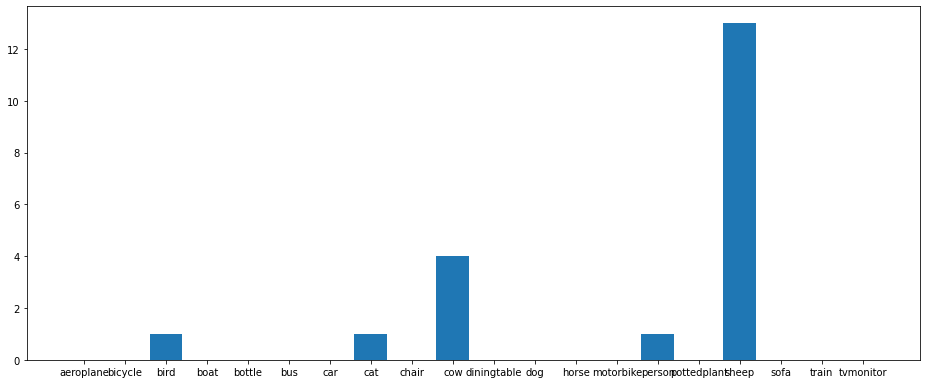

1


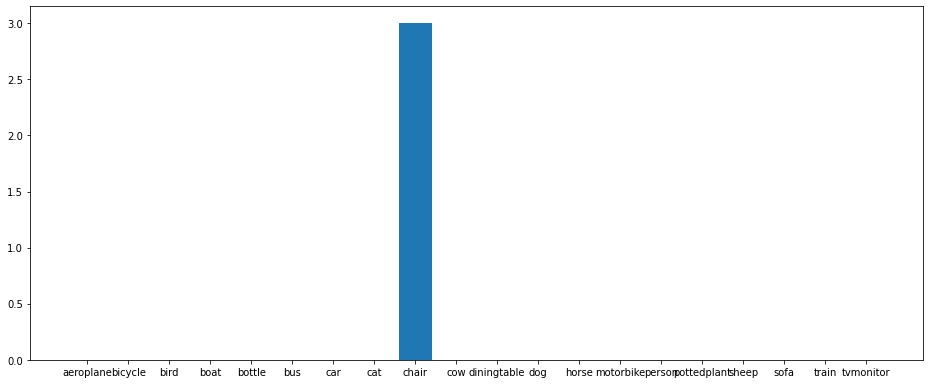

2


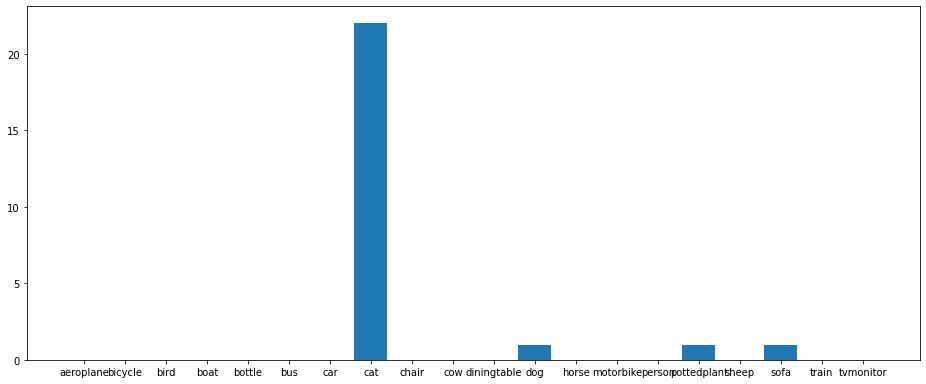

3


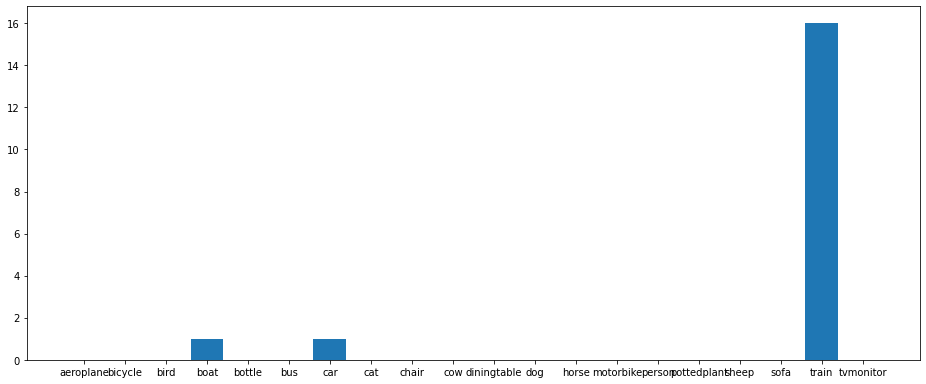

4


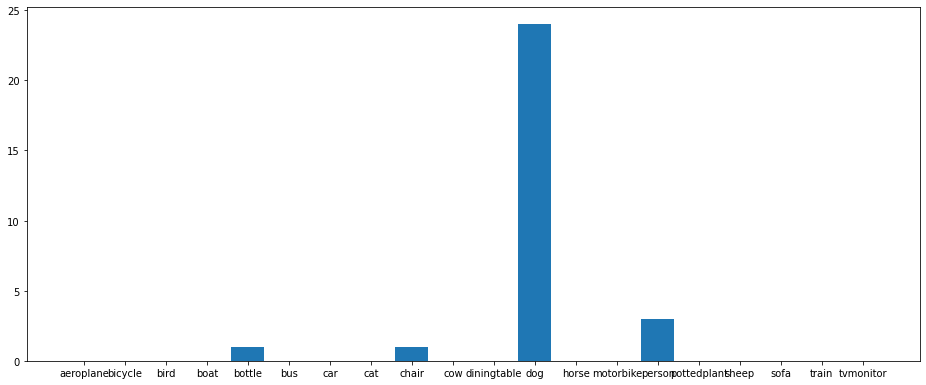

5


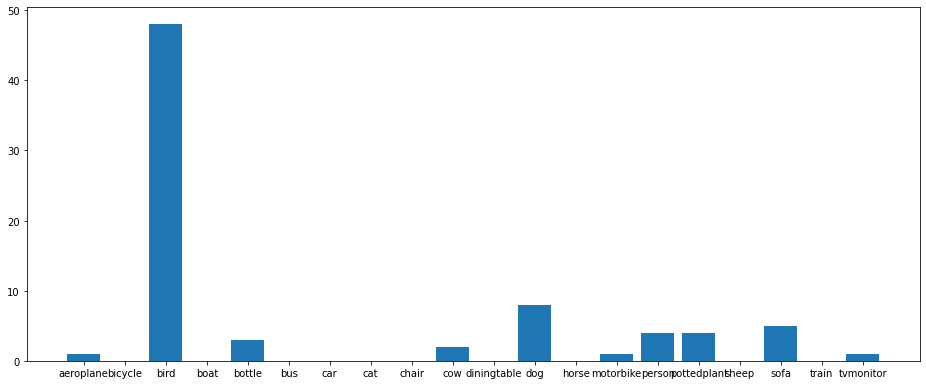

6


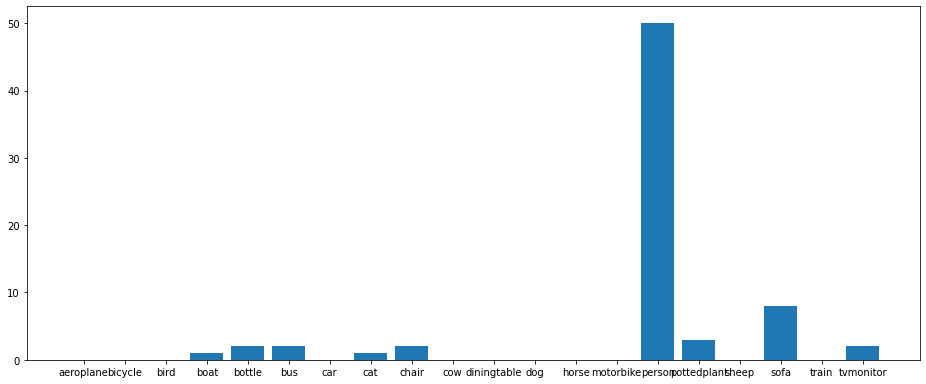

7


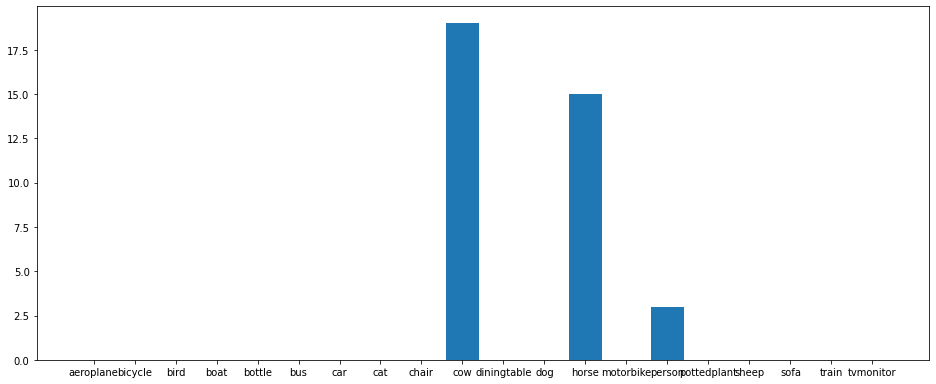

8


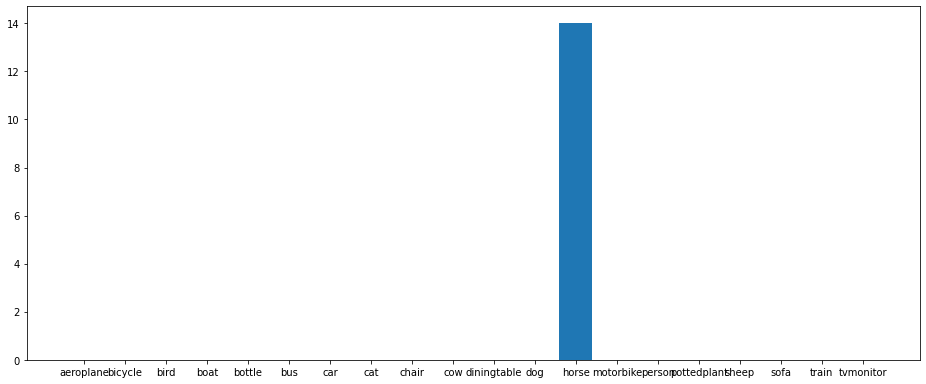

9


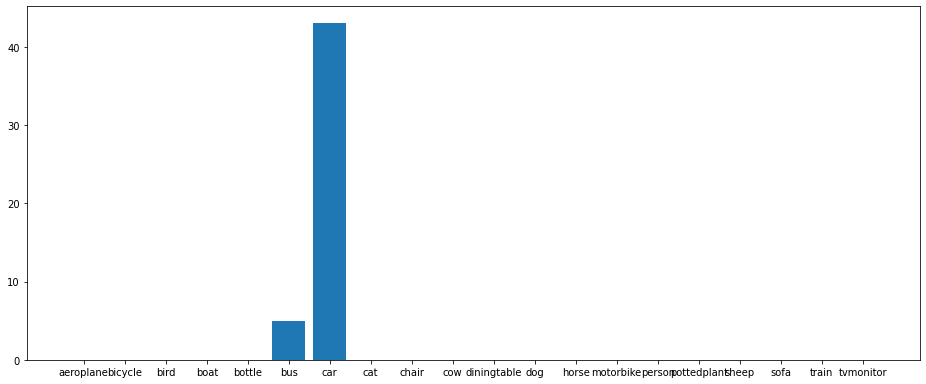

10


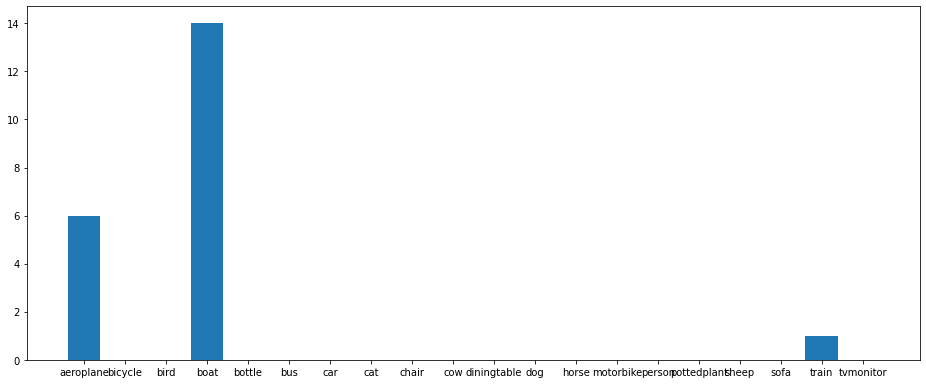

11


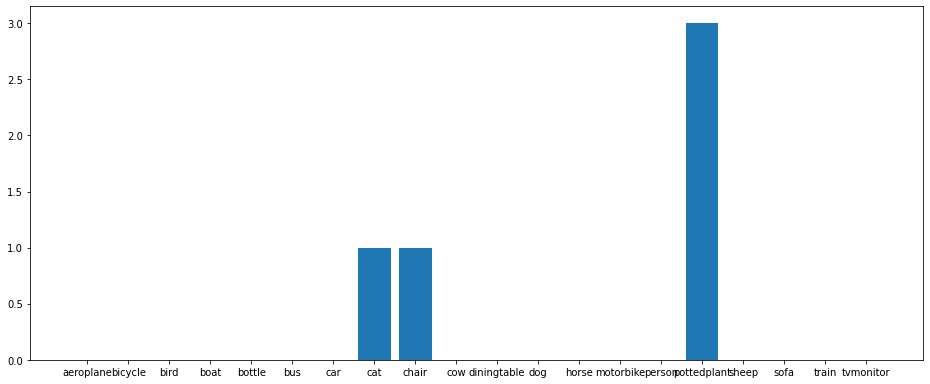

12


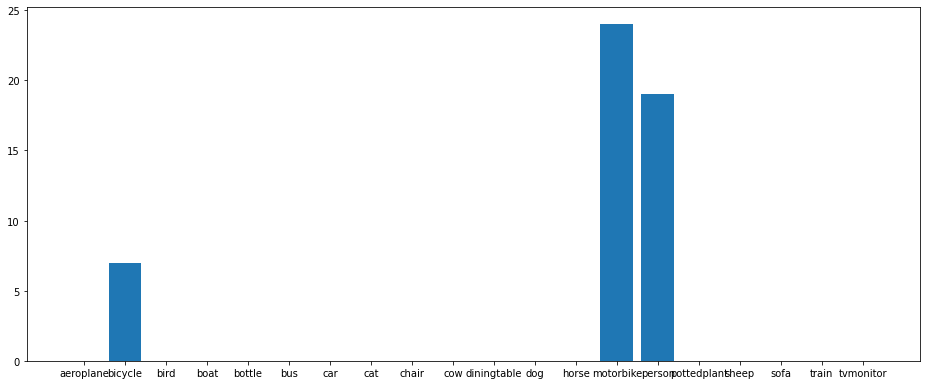

13


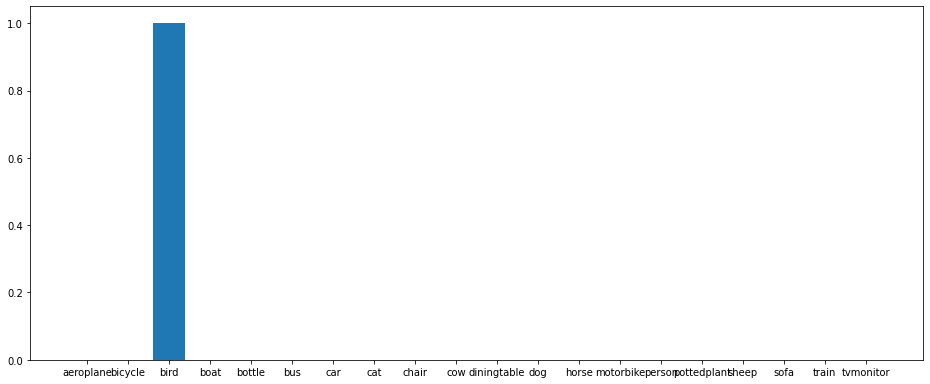

14


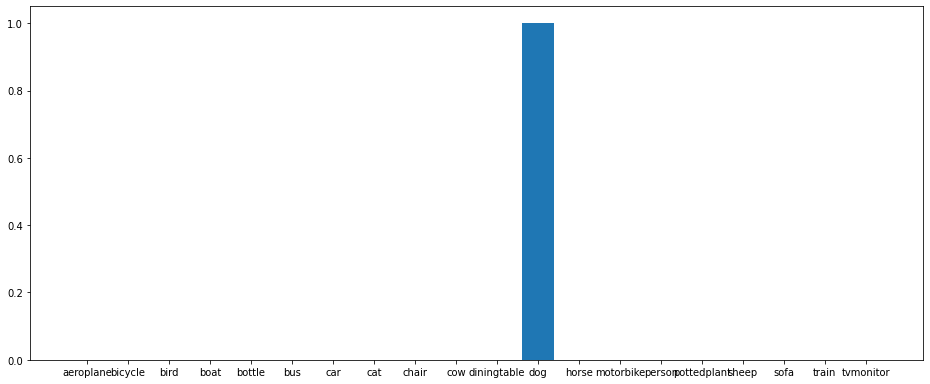

15


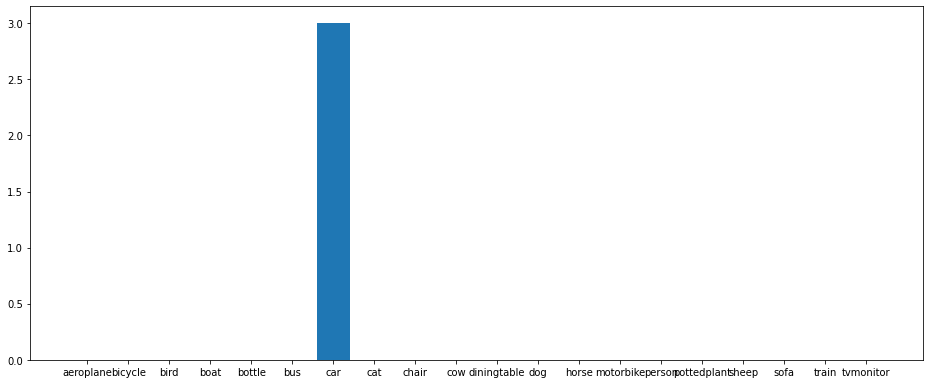

16


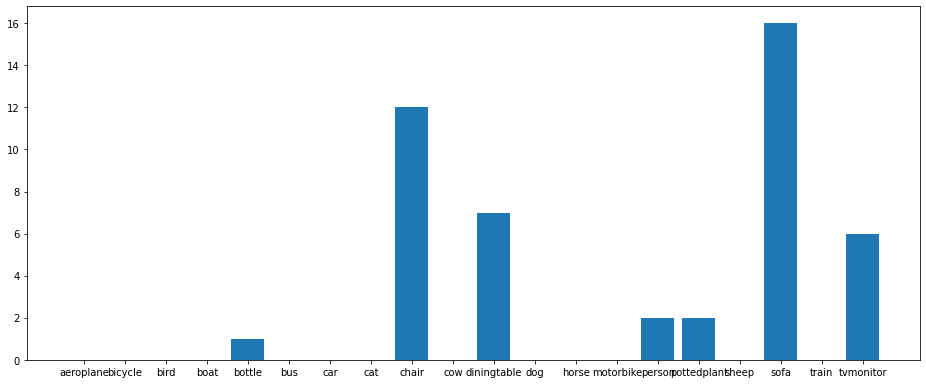

17


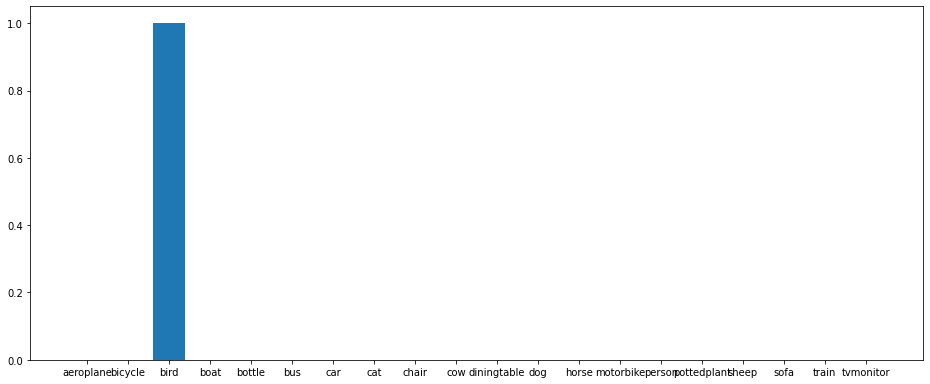

18


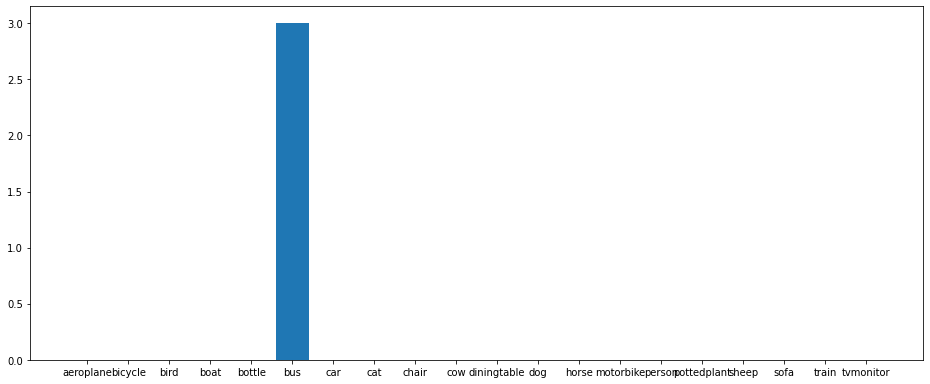

19


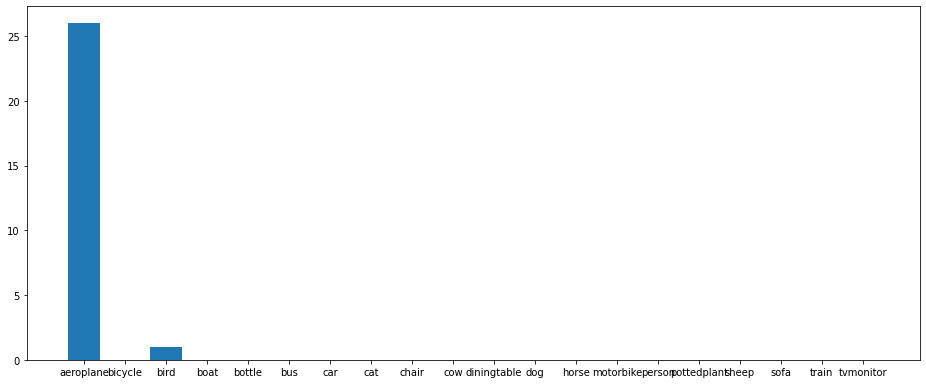

In [41]:
#here we check which labels are assigned to each cluster if you set use all all labels will be considered otherwise jsut the label with the maximum area estimate will be used
use_all_labels=False
####################

hist=cluster_histogramm(train_filtered_list,pck.labels_,y,use_all=use_all_labels)

for i in range(hist.shape[0]):  
    print(i)
    fig = plt.gcf()
    fig.set_size_inches(16, 6.5)
    plt.bar(np.arange(0,20),hist[i],tick_label=_VOC_LABELS) 
    plt.show()

In [42]:
#Here we look at 2 explanations for the cluster. The first uses only the distribution and does not use constraints in the clusterer.
#The second uses a classfifier to predict cluster assignment. It cant see the labels directly but uses some of them indirectly
#because they can appear in the labels assigned by PCK Means.
#Note that the explanations can contradict each other because of this. Due to the weight w the assigned label may be contradicting the label suggested by the underlying distribution.

#Here the image to be explained can be set
explained_image_index=0
################################
print("assigned cluster: "+str(pck.labels_[explained_image_index]))
print_label_by_distribution(pck,explained_image_index,features)
#Here the cluster to which an assignment should be explained can be set
explained_cluster=pck.labels_[explained_image_index]
################################
#Here batch size (decrease if not enough memory) and number of samples (decreause for speedup but lower quality explanations) can be set
lime_batch_size=250
lime_number_samples=1000

assigned cluster: 8


ValueError: Expected 2D array, got 1D array instead:
array=[ 5.41450024 -0.2756139   0.22696179 ... -0.65683168  0.5824548
  0.24912848].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [43]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation1 = explainer.explain_instance(train_filtered_list[explained_image_index]["image"]/255.0, classifier_function_creator(pck,euclidean_distances),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=lime_number_samples,batch_size =lime_batch_size)

NameError: name 'lime_number_samples' is not defined

In [ ]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation1.get_image_and_mask(explained_cluster, positive_only=False, num_features=25, hide_rest=False)
plt.imshow(mark_boundaries(temp/1.5, mask))

In [ ]:
clf2 = RandomForestClassifier(max_depth=10, random_state=0)
explanation2 = explainer.explain_instance(train_filtered_list[explained_image_index]["image"]/255.0, classifier_function_creator2(clf2,features,pck.labels_),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=lime_number_samples,batch_size =lime_batch_size)

In [ ]:
from skimage.segmentation import mark_boundaries
temp2, mask2 = explanation2.get_image_and_mask(explained_cluster, positive_only=False, num_features=25, hide_rest=False)
plt.imshow(mark_boundaries(temp2/1.5, mask2))

In [ ]:
#Here follow other features explained
#TODO show class assigned by distribution
#TODO adjust weight w for cld?

In [ ]:
#effnet explanations
if EFFNET_ENABLED:
    pck_effnet = PCKMeans(n_clusters=n_cluster,max_iter=100,w=500)
    #pck_effnet._initialize_cluster_centers=types.MethodType( initialize_cluster_centers, pck_effnet )
    pck_effnet.fit(feature_effnet, ml=pairwise_constraints[0], cl=pairwise_constraints[1])
    #metrics.adjusted_rand_score(y, pck_effnet.labels_)

    #Here you can change the explained cluster
    explained_cluster=pck_effnet.labels_[explained_image_index]

    print("Adjusted random score using max labels"+str(metrics.adjusted_rand_score(y, pck_effnet.labels_)))
    print("Silhouette score "+str(metrics.silhouette_score(features, pck_effnet.labels_)))

    explainer = lime_image.LimeImageExplainer()
    explanation1 = explainer.explain_instance(train_filtered_list[explained_image_index]["image"]/255.0, classifier_function_creator(pck_effnet,euclidean_distances,"effnet"),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=lime_number_samples,batch_size =lime_batch_size)
    clf2 = RandomForestClassifier(max_depth=10, random_state=0)
    explanation2 = explainer.explain_instance(train_filtered_list[explained_image_index]["image"]/255.0, classifier_function_creator2(clf2,feature_effnet,pck_effnet.labels_,"effnet"),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=lime_number_samples,batch_size =lime_batch_size)
    from skimage.segmentation import mark_boundaries
    temp, mask = explanation1.get_image_and_mask(explained_cluster, positive_only=False, num_features=25, hide_rest=False)
    plt.imshow(mark_boundaries(temp/1.5, mask))
    plt.show()

    from skimage.segmentation import mark_boundaries
    temp2, mask2 = explanation2.get_image_and_mask(explained_cluster, positive_only=False, num_features=25, hide_rest=False)
    plt.imshow(mark_boundaries(temp2/1.5, mask2))
    plt.show()

In [ ]:
#orb explanations
import types

if ORB_ENABLED:
    pck_orb = PCKMeans(n_clusters=n_cluster,max_iter=100,w=500)
    #pck_orb._initialize_cluster_centers=types.MethodType( initialize_cluster_centers, pck_orb )
    pck_orb.fit(feature_orb, ml=pairwise_constraints[0], cl=pairwise_constraints[1])
    #metrics.adjusted_rand_score(y, pck_orb.labels_)

    #Here you can change the explained cluster
    explained_cluster=pck_orb.labels_[explained_image_index]

    print("Adjusted random score using max labels"+str(metrics.adjusted_rand_score(y, pck_orb.labels_)))
    print("Silhouette score "+str(metrics.silhouette_score(features, pck_orb.labels_)))

    explainer = lime_image.LimeImageExplainer()
    explanation1 = explainer.explain_instance(train_filtered_list[explained_image_index]["image"]/255.0, classifier_function_creator(pck_orb,euclidean_distances,"orb"),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=lime_number_samples,batch_size =lime_batch_size)
    clf2 = RandomForestClassifier(max_depth=10, random_state=0)
    explanation2 = explainer.explain_instance(train_filtered_list[explained_image_index]["image"]/255.0, classifier_function_creator2(clf2,feature_orb,pck_orb.labels_,"orb"),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=lime_number_samples,batch_size =lime_batch_size)
    from skimage.segmentation import mark_boundaries
    temp, mask = explanation1.get_image_and_mask(explained_cluster, positive_only=False, num_features=25, hide_rest=False)
    plt.imshow(mark_boundaries(temp/1.5, mask))
    plt.show()
    from skimage.segmentation import mark_boundaries
    temp2, mask2 = explanation2.get_image_and_mask(explained_cluster, positive_only=False, num_features=25, hide_rest=False)
    plt.imshow(mark_boundaries(temp2/1.5, mask2))
    plt.show()

In [ ]:
#color layout descriptor explanations
if CLD_ENABLED:
    import types

    fitted=False
    while not fitted:
        try:
            pck_cld = PCKMeans(n_clusters=n_cluster,max_iter=100,w=50000)
            pck_cld._initialize_cluster_centers=types.MethodType( initialize_cluster_centers, pck_cld )
            pck_cld.fit(feature_cld, ml=pairwise_constraints[0], cl=pairwise_constraints[1])
            fitted=True
        except Exception as e:
            if str(e)=="":
                pass
            else:
                raise e
    print("passed")
    #metrics.adjusted_rand_score(y, pck_cld.labels_)
    #Here you can change the explained cluster
    explained_cluster=pck_cld.labels_[explained_image_index]

    print("Adjusted random score using max labels"+str(metrics.adjusted_rand_score(y, pck_cld.labels_)))
    print("Silhouette score "+str(metrics.silhouette_score(features, pck_cld.labels_)))

    explainer = lime_image.LimeImageExplainer()
    explanation1 = explainer.explain_instance(train_filtered_list[explained_image_index]["image"]/255.0, classifier_function_creator(pck_cld,euclidean_distances,"cld"),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=lime_number_samples,batch_size =lime_batch_size)
    clf2 = RandomForestClassifier(max_depth=10, random_state=0)
    explanation2 = explainer.explain_instance(train_filtered_list[explained_image_index]["image"]/255.0, classifier_function_creator2(clf2,feature_cld,pck_cld.labels_,"cld"),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=lime_number_samples,batch_size =lime_batch_size)
    from skimage.segmentation import mark_boundaries
    temp, mask = explanation1.get_image_and_mask(explained_cluster, positive_only=False, num_features=25, hide_rest=False)
    plt.imshow(mark_boundaries(temp/1.5, mask))
    plt.show()
    from skimage.segmentation import mark_boundaries
    temp2, mask2 = explanation2.get_image_and_mask(explained_cluster, positive_only=False, num_features=25, hide_rest=False)
    plt.imshow(mark_boundaries(temp2/1.5, mask2))
    plt.show()

In [ ]:
#surf explanations
if SURF_ENABLED:
    pck_surf = PCKMeans(n_clusters=n_cluster,max_iter=100,w=500)
    #pck_surf._initialize_cluster_centers=types.MethodType( initialize_cluster_centers, pck_surf )
    pck_surf.fit(feature_surf, ml=pairwise_constraints[0], cl=pairwise_constraints[1])
    #metrics.adjusted_rand_score(y, pck_surf.labels_)

    #Here you can change the explained cluster
    explained_cluster=pck_surf.labels_[explained_image_index]

    print("Adjusted random score using max labels"+str(metrics.adjusted_rand_score(y, pck_surf.labels_)))
    print("Silhouette score "+str(metrics.silhouette_score(features, pck_surf.labels_)))

    explainer = lime_image.LimeImageExplainer()
    explanation1 = explainer.explain_instance(train_filtered_list[explained_image_index]["image"]/255.0, classifier_function_creator(pck_surf,euclidean_distances,"surf"),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=lime_number_samples,batch_size =lime_batch_size)
    clf2 = RandomForestClassifier(max_depth=10, random_state=0)
    explanation2 = explainer.explain_instance(train_filtered_list[explained_image_index]["image"]/255.0, classifier_function_creator2(clf2,feature_surf,pck_surf.labels_,"surf"),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=lime_number_samples,batch_size =lime_batch_size)
    from skimage.segmentation import mark_boundaries
    temp, mask = explanation1.get_image_and_mask(explained_cluster, positive_only=False, num_features=25, hide_rest=False)
    plt.imshow(mark_boundaries(temp/1.5, mask))
    plt.show()

    from skimage.segmentation import mark_boundaries
    temp2, mask2 = explanation2.get_image_and_mask(explained_cluster, positive_only=False, num_features=25, hide_rest=False)
    plt.imshow(mark_boundaries(temp2/1.5, mask2))
    plt.show()

In [ ]:
#hash explanation
if HASHING_ENABLED:
    pck_hash = PCKMeans(n_clusters=n_cluster,max_iter=100,w=500)
    #pck_hash._initialize_cluster_centers=types.MethodType( initialize_cluster_centers, pck_hash )
    pck_hash.fit(feature_hash, ml=pairwise_constraints[0], cl=pairwise_constraints[1])
    #metrics.adjusted_rand_score(y, pck_hash.labels_)

    #Here you can change the explained cluster
    explained_cluster=pck_hash.labels_[explained_image_index]

    print("Adjusted random score using max labels"+str(metrics.adjusted_rand_score(y, pck_hash.labels_)))
    print("Silhouette score "+str(metrics.silhouette_score(features, pck_hash.labels_)))

    explainer = lime_image.LimeImageExplainer()
    explanation1 = explainer.explain_instance(train_filtered_list[explained_image_index]["image"]/255.0, classifier_function_creator(pck_hash,euclidean_distances,"hash"),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=lime_number_samples,batch_size =lime_batch_size)
    clf2 = RandomForestClassifier(max_depth=10, random_state=0)
    explanation2 = explainer.explain_instance(train_filtered_list[explained_image_index]["image"]/255.0, classifier_function_creator2(clf2,feature_hash,pck_hash.labels_,"hash"),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=lime_number_samples,batch_size =lime_batch_size)
    from skimage.segmentation import mark_boundaries
    temp, mask = explanation1.get_image_and_mask(explained_cluster, positive_only=False, num_features=25, hide_rest=False)
    plt.imshow(mark_boundaries(temp/1.5, mask))
    plt.show()
    from skimage.segmentation import mark_boundaries
    temp2, mask2 = explanation2.get_image_and_mask(explained_cluster, positive_only=False, num_features=25, hide_rest=False)
    plt.imshow(mark_boundaries(temp2/1.5, mask2))
    plt.show()

In [ ]:
#here are example images for the clusters
#This made more senses than asking the expert again wether the clusters are correct and calculating a score based on that.
# Mainly because it is way faster to check multiple images at once.

In [ ]:
def show_example_images(algorithm,data_list,cluster=0,ammount=10):
    counter = 0
    for k,data in enumerate(data_list):
            if counter == ammount:
                break
            im = data['image']
            pred = algorithm.labels_[k]
            if pred == cluster:
                    plt.imshow(im)
                    plt.show()
                    counter += 1
                    if counter == ammount:
                        break

In [ ]:
show_example_images(pck,train_filtered_list,cluster=0,ammount=10)

In [ ]:
show_example_images(pck_effnet,train_filtered_list,cluster=0,ammount=10)

In [ ]:
show_example_images(pck_surf,train_filtered_list,cluster=0,ammount=10)

In [ ]:
show_example_images(pck_orb,train_filtered_list,cluster=0,ammount=10)

In [ ]:
show_example_images(pck_cld,train_filtered_list,cluster=1,ammount=10)

In [ ]:
show_example_images(pck_hash,train_filtered_list,cluster=0,ammount=10)

In [ ]:
#here follow calculations for images due to the large number of queries they need only labeloracle is used
#i would not recommend recomputing them

#Also all features have to be enabled to calculate the comparision!

In [ ]:
start=time.time()
import multiprocessing
pool = multiprocessing.Pool(processes=8)
kwargs={"power_of_query_count":5,"tries":2}
kwargs1={"power_of_query_count":5,"tries":2,"weight":50000}
kwargs2={"power_of_query_count":4,"tries":2,"use_explore_consolidate":False}
kwargs3={"power_of_query_count":4,"tries":2,"use_explore_consolidate":True}
async_result1=pool.apply_async(calculate_score_per_query,(features,train_filtered_list,n_cluster,y),kwargs)
async_result2=pool.apply_async(calculate_score_per_query,(feature_surf,train_filtered_list,n_cluster,y),kwargs)
async_result3=pool.apply_async(calculate_score_per_query,(feature_effnet,train_filtered_list,n_cluster,y),kwargs)
async_result4=pool.apply_async(calculate_score_per_query,(feature_cld,train_filtered_list,n_cluster,y),kwargs1)
async_result5=pool.apply_async(calculate_score_per_query,(feature_hash,train_filtered_list,n_cluster,y),kwargs)
async_result6=pool.apply_async(calculate_score_per_query,(feature_orb,train_filtered_list,n_cluster,y),kwargs)
async_result7=pool.apply_async(calculate_score_per_query,(features,train_filtered_list,n_cluster,y),kwargs2)
async_result8=pool.apply_async(calculate_score_per_query,(features,train_filtered_list,n_cluster,y),kwargs3)

values_random,values_sil,querry_counts = async_result1.get(timeout=1800)
print("1")
print(time.time()-start)
values_random_surf,values_sil_surf,querry_counts = async_result2.get(timeout=1800)
print("2")
print(time.time()-start)
values_random_effnet,values_sil_effnet,querry_counts = async_result3.get(timeout=1800)
print("3")
print(time.time()-start)
values_random_cld,values_sil_cld,querry_counts=async_result4.get(timeout=1800)
print("4")
print(time.time()-start)
values_random_hash,values_sil_hash,querry_counts=async_result5.get(timeout=1800)
print("5")
print(time.time()-start)
values_random_orb,values_orb_hash,querry_counts=async_result6.get(timeout=1800)
print("6")
print(time.time()-start)
values_random_random,values_sil_random,querry_counts2 = async_result7.get(timeout=1800)
print("7")
print(time.time()-start)
values_random_explore,values_sil_explore,querry_counts2 = async_result8.get(timeout=1800)
print("8")
pool.close()
pool.join()
print(time.time()-start)

In [ ]:
#TODO use standard error insteaf of deviation?
fig, ax = plt.subplots(1, 1)
fig.dpi=300
ax.set_title("Adjusted Random Score for number of queries")
ax.set_xlabel("number of queries")
ax.set_ylabel("Score")
score_arr=np.array(values_random)
train_scores_mean = np.mean(score_arr, axis=1)
train_scores_std = np.std(score_arr, axis=1)
ax.grid()
ax.fill_between(querry_counts, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax.plot(querry_counts, train_scores_mean, 'o-', color="r",
            label="Training score")
#ax.tick_params(labelsize=text_fontsize)
#ax.legend(loc="best", fontsize=text_fontsize)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.dpi=300
ax.set_title("Silhouette score for number of queries")
ax.set_xlabel("number of queries")
ax.set_ylabel("Score")
score_arr=np.array(values_sil)
train_scores_mean = np.mean(score_arr, axis=1)
train_scores_std = np.std(score_arr, axis=1)
ax.grid()
ax.fill_between(querry_counts, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax.plot(querry_counts, train_scores_mean, 'o-', color="r",
            label="Training score")
#ax.tick_params(labelsize=text_fontsize)
#ax.legend(loc="best", fontsize=text_fontsize)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.dpi=300
ax.set_title("Adjusted Random Score using labels over different numbers of queries")
ax.set_xlabel("Number of queries")
ax.set_ylabel("Adjusted Random Score")
#dict_random={"surf":values_random_surf,"cld":values_random_cld,"ahash":values_random_hash}
dict_random={"all":values_random,"effnet":values_random_effnet,"surf":values_random_surf,"cld":values_random_cld,"ahash":values_random_hash,"orb":values_random_orb}
for key in dict_random:
    score_arr=np.array(dict_random[key])
    train_scores_mean = np.mean(score_arr, axis=1)
    train_scores_std = np.std(score_arr, axis=1)
    ax.grid()
    ax.fill_between(querry_counts, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.2)
    ax.plot(querry_counts, train_scores_mean, 'o-',
                label=key)
#ax.tick_params(labelsize=text_fontsizew)
#ax.legend(loc="best", fontsize=text_fontsize)
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.dpi=300
ax.set_title("Silhouette score over different numbers of queries")
ax.set_xlabel("Number of queries")
ax.set_ylabel("Adjusted Random Score")
#dict_random={"surf":values_random_surf,"cld":values_random_cld,"ahash":values_random_hash}
dict_random={"all":values_sil,"effnet":values_sil_effnet,"surf":values_sil_surf,"cld":values_sil_cld,"ahash":values_sil_hash}
for key in dict_random:
    score_arr=np.array(dict_random[key])
    train_scores_mean = np.mean(score_arr, axis=1)
    train_scores_std = np.std(score_arr, axis=1)
    ax.grid()
    ax.fill_between(querry_counts, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.2)
    ax.plot(querry_counts, train_scores_mean, 'o-',
                label=key)
#ax.tick_params(labelsize=text_fontsizew)
#ax.legend(loc="best", fontsize=text_fontsize)
plt.legend()
plt.show()

In [ ]:

fig, ax = plt.subplots(1, 1)
fig.dpi=300
ax.set_title("Adjusted Random Score using labels over different numbers of queries")
ax.set_xlabel("Number of queries")
ax.set_ylabel("Adjusted Random Score")
#dict_random={"surf":values_random_surf,"cld":values_random_cld,"ahash":values_random_hash}
dict_random={"random":values_random_random,"explore consolidate":values_random_explore}
for key in dict_random:
    score_arr=np.array(dict_random[key])
    train_scores_mean = np.mean(score_arr, axis=1)
    train_scores_std = np.std(score_arr, axis=1)
    ax.grid()
    ax.fill_between(querry_counts2, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.2)
    ax.plot(querry_counts2, train_scores_mean, 'o-',
                label=key)
#ax.tick_params(labelsize=text_fontsizew)
#ax.legend(loc="best", fontsize=text_fontsize)
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.dpi=300
ax.set_title("Silhouette score over different numbers of queries")
ax.set_xlabel("Number of queries")
ax.set_ylabel("Adjusted Random Score")
#dict_random={"surf":values_random_surf,"cld":values_random_cld,"ahash":values_random_hash}
dict_random={"random":values_sil_random,"explore consolidate":values_sil_explore}
for key in dict_random:
    score_arr=np.array(dict_random[key])
    train_scores_mean = np.mean(score_arr, axis=1)
    train_scores_std = np.std(score_arr, axis=1)
    ax.grid()
    ax.fill_between(querry_counts2, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.2)
    ax.plot(querry_counts2, train_scores_mean, 'o-',
                label=key)
#ax.tick_params(labelsize=text_fontsizew)
#ax.legend(loc="best", fontsize=text_fontsize)
plt.legend()
plt.show()

In [ ]:
#TODO test LABELORRACLE with heuristic